In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample

# Get the absolute path of the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the correct utils directory to sys.path
utils_dir = os.path.join(parent_dir, "utils")
if not os.path.isdir(utils_dir):
    raise FileNotFoundError(f"Custom 'utils' directory not found at: {utils_dir}")

sys.path.insert(0, parent_dir)  # Add parent directory to sys.path

# Now import the correct functions
from utils.get_closest_fch import get_closest_fch
from utils.gen_ofdm import gen_ofdm
from utils.plot_spec import plot_spec
from utils.plot_pwr import plot_pwr


This script showcases the genOFDM function, on which the Starlink-specific functions are based on. In this playground, you can view a spectrogram, a power plot (PSD or Power vs time), and view a constellation plot of the sub-carrier data.

In [2]:
# --------------------------------------
#                Option                
# --------------------------------------
specPlot_en = True
pwrPlot_en = True
constPlot_en = True

After choosing how many consecutive OFDM symbols will be generated you can customize the signal.

In [3]:
# --------------------------------------
#               Params                  
# --------------------------------------
NFFT = 2**10  # Number of FFT points for spectrogram, reduced later if too many
Nsym = 298

You can choose an SNR, a receiver sampling rate Fsr, a receiver center frequency, a CFO (beta), the modulation index, the modulation scheme, the number of subcarriers (N), the cyclic prefix length (Ng), and the channel center, and channel bandwidth. Also, a toggle to enable the gutter (4 center sub-carriers have no power in Starlink).

/Users/jack/Desktop/starlink/starlink/utils/plot_spec.py:73: UserWarning: Input data is complex, switching to return_onesided=False
  fVec, tVec, Sxx = spectrogram(
/Users/jack/Desktop/starlink/starlink/utils/plot_spec.py:90: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(tVec + tstart, fVec / 1e6, Sxx_dB, shading="auto", cmap="jet", vmin=-90)


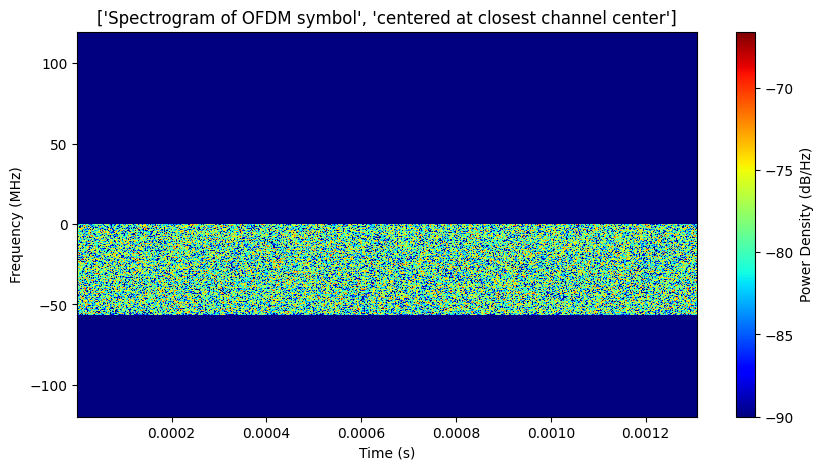

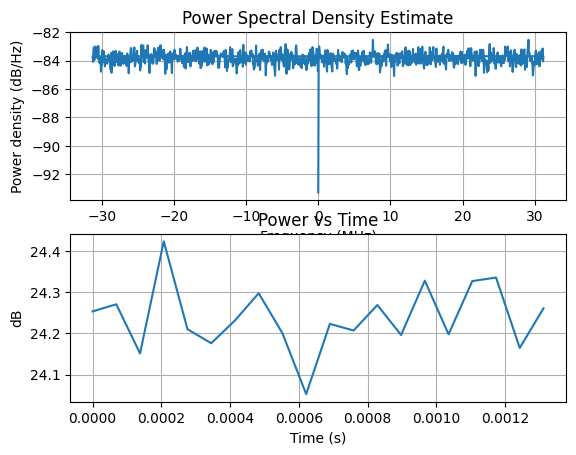

In [4]:
# --------------------------------------
#            OFDM Input Params         
# --------------------------------------

# Signal-to-noise ratio (SNR) in dB
Nysm = 298

s = {}
s["SNRdB"] = np.nan

# Receiver sample rate
s["Fsr"] = 62.5e6

# Receiver center frequency, in Hz
s["Fcr"] = get_closest_fch(11.775e9) - 25e6
s["beta"] = 0
s["Midx"] = 4
s["type"] = "QAM"
s["N"] = 1024
s["Ng"] = 32
s["Nsym"] = Nsym  # Assuming Nsym is defined elsewhere
s["Fc"] = get_closest_fch(11.775e9)
s["Fs"] = 240e6
s["gutter"] = 1

# --------------------------------------
#           Generate Signal            
# --------------------------------------
y = gen_ofdm(s)

# --------------------------------------
#            Spectrogram                
# --------------------------------------
if specPlot_en:
    t = "Spectrogram of OFDM symbol"
    Stitle = [t, "centered at closest channel center"]
    F = 240e6 / 1024
    chIdx = round((s["Fcr"] / 1e9 - 10.7 - F / 2 / 1e9) / 0.25 + 0.5)
    Fcii = (10.7e9 + F / 2 + 250e6 * (chIdx - 0.5))
    plot_spec(y, 0, 0, s["Fcr"], s["Fsr"], Fcii, s["Fs"], NFFT, Stitle)

# --------------------------------------
#           Power Plots                 
# --------------------------------------
if pwrPlot_en:
    Stitle = ["Spectrogram of Starlink signal", "centered at closest channel center"]
    plot_pwr(y, 20, 0, len(y) / s["Fsr"], s["Fsr"], NFFT)

# --------------------------------------
#         Constellation Plots           
# --------------------------------------
sc_mag_threshold = 0.95  # Between 0 and 1

if constPlot_en:
    # Resample and center to channel
    if s["Fsr"] != 240e6:
        tVec = np.arange(len(y)) / s["Fsr"]
        y = resample(y, int(len(y) * 240e6 / s["Fsr"]))
    
    if get_closest_fch(s["Fcr"]) - s["Fcr"] != 0:
        tVec = np.arange(len(y)) / 240e6
        Fshift = get_closest_fch(s["Fcr"]) - s["Fcr"]
        y = y * np.exp(-1j * 2 * np.pi * Fshift * tVec)

    # Zero padding
    pad_length = (1056) * np.ceil(len(y) / 1056).astype(int) - len(y)
    yVec = np.concatenate([y, np.zeros(pad_length, dtype=complex)])

    # Remove CP
    y = yVec.reshape((1056, -1))
    y = y[32:, :]

    # Take FFT
    Y = (1 / np.sqrt(1024)) * np.fft.fft(y, axis=0)

    # Find good subchannels
    idx = np.where(np.abs(Y) / np.max(np.abs(Y)) > sc_mag_threshold)

    # Set gutter values to NaN
    Y[:2, :] = np.nan
    Y[-2:, :] = np.nan

    l, w = Y.shape
    input("Press any key to start constellation plotting loop...")  # Equivalent to pause
    plt.figure()

    for ii in range(w):
        plt.plot(Y[idx, ii], "*")
        plt.pause(1)
